### Maxwell-Boltzmann Distribution

In [2]:
import numpy as np
import scipy as sy
from numba import jit # optional to speed up code; comment out if not installed

Define a function to create a set a randomly distributed particles.

In [131]:
def initial_conditions(N, v0):
    
    # create arrays of random numbers for (x, y) locations of each particle
    x, y = np.random.random(N), np.random.random(N)
    # create arrays of zeros for the initial velocities of each particle
    vx, vy = (np.random.random(N) - 0.5)*float(v0), (np.random.random(N) - 0.5)*float(v0)
    
    return x, y, vx, vy

Define a function to apply classical dynamics for a single time step $dt$.

In [109]:
@jit(nopython=True) # comment out this line if numba not installed
def classical_step(x, y, vx, vy, dt, N):
    
    # set strength of particle repulsion (effectively radius of interaction)
    strength = 1
    
    # create arrays for updated locations and velocities
    x_, y_, vx_, vy_ = np.zeros_like(x), np.zeros_like(y), np.zeros_like(vx), np.zeros_like(vy)
    
    # consider forces acting on each particle
    for i in range(len(x)):
        # set acceleration on the i'th particle to zero (initially)
        ax, ay = 0., 0.
        
        # estimate the electrostactic force on the i'th particle from each other particle
        for j in range(len(x)):
            # sum contribution from this particle to x- and y-components of the acceleration
            if not j == i:
                ax = ax + strength/(2*np.pi*np.sqrt(N))*(x[i] - x[j])/((x[i] - x[j])**2 + (y[i] - y[j])**2)
                ay = ay + strength/(2*np.pi*np.sqrt(N))*(y[i] - y[j])/((x[i] - x[j])**2 + (y[i] - y[j])**2)
                    # this is Coulomb's Law for a 2D plane with an arbitrary strength to represent collisions
            
        # calculate updated location and velocity of i'th particle
        x_[i] = x[i] + vx[i]*dt + 1/2.*ax*dt**2
        y_[i] = y[i] + vy[i]*dt + 1/2.*ay*dt**2
        vx_[i] = vx[i] + ax*dt
        vy_[i] = vy[i] + ay*dt
        
        # reflect particle off the boundary if it leaves the box during the time step
        # will not work if particles travel across width of box in less than a single time step
        if x_[i] < 0:
            x_[i] = -x_[i]
            vx_[i] = -vx_[i]
        if x_[i] > 1:
            x_[i] = 2 - x_[i]
            vx_[i] = -vx_[i]
        if y_[i] < 0:
            y_[i] = -y_[i]
            vy_[i] = -vy_[i]
        if y_[i] > 1:
            y_[i] = 2 - y_[i]
            vy_[i] = -vy_[i]
        
    return x_, y_, vx_, vy_

Define function to apply numerous iterations of the classical dynamics function.

In [110]:
def simualtion(N, t, dt, v0):
    
    # initial conditions for particles
    x, y, vx, vy = initial_conditions(N, v0)
    # create lists to store time, location and velocity outputs for each time step 
    t_array, x_array, y_array, vx_array, vy_array = [0.], [x], [y], [vx], [vy]
    
    # evaluate classical dynamics for total time
    tc, i = 0., 0
    while tc < t:
        # update current time step, ensuring final step is exactly t
        if tc + dt > t:
            dt = t - tc
            tc = t
        else:
            tc = tc + dt
        i = i + 1
        
        # run classical dynamics for a time step
        x, y, vx, vy = classical_step(x, y, vx, vy, dt, N)
        # add new time step to output arrays
        t_array.append(tc)
        x_array.append(x)
        y_array.append(y)
        vx_array.append(vx)
        vy_array.append(vy)
        
    return t_array, x_array, y_array, vx_array, vy_array

Run the simulation. Ensure $dt$ is sufficiently small that particles have not escaped the box by the final time step.

In [148]:
v0 = 1
t_array, x_array, y_array, vx_array, vy_array = simualtion(100, 10, 0.00001, v0)

In [149]:
print(t_array[-1], x_array[-1], y_array[-1], vx_array[-1], vy_array[-1])

10 [0.86328171 0.98790797 0.40790912 0.96292946 0.84695334 0.73450917
 0.09295767 0.40391141 0.91338915 0.83942986 0.19845028 0.12751348
 0.02517188 0.19468719 0.09713874 0.54197641 0.84304917 0.99038816
 0.99791528 0.95938154 0.01715176 0.23507876 0.23228064 0.98813286
 0.31537516 0.19786975 0.29421461 0.98118839 0.13796512 0.87272491
 0.52299534 0.72271329 0.17343563 0.92964061 0.30290695 0.15235781
 0.1537795  0.9107467  0.4553985  0.38456761 0.75113394 0.75726495
 0.70259183 0.12718286 0.65099904 0.01395873 0.25947635 0.50616904
 0.93087453 0.95208062 0.70508938 0.00572625 0.34979369 0.38694743
 0.65257433 0.96886891 0.41170316 0.22089644 0.88523762 0.89679641
 0.23480228 0.10052133 0.15828434 0.08633951 0.13602577 0.48309202
 0.09385465 0.07998189 0.05829976 0.90607354 0.99876665 0.76317027
 0.89876342 0.84922885 0.55079873 0.56551384 0.5640458  0.67990336
 0.36171553 0.07678188 0.99470485 0.77708185 0.24296809 0.60013359
 0.9544213  0.88335669 0.82164624 0.40426658 0.08909681 0.5

Define a function to plot the velocity distribution.

In [154]:
from matplotlib import pyplot as plt
from matplotlib import rc

def velocity_plotter(vx, vy, v0):

    # set up latex labels on plot (optional)
    try:
        rc('text', usetex=True) # can try usetex=False
        rc('font', size=14)
        rc('legend', fontsize=14)
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    except:
        pass

    # create figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # set axis labels
    ax.set_xlabel(r'Velocity (arbitrary units)')
    ax.set_ylabel(r'Number of particles')

    ax.hist(np.sqrt(np.asarray(vx).flatten()**2 + np.asarray(vy).flatten()**2), bins=np.arange(0, 3*v0, v0/100), \
            color='red')

    plt.show()

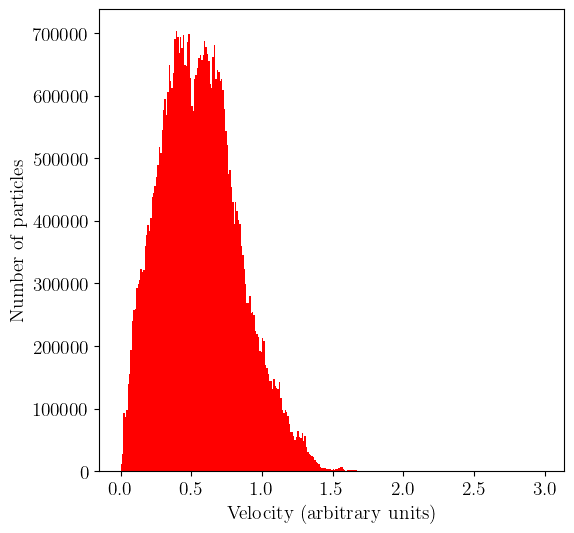

In [155]:
velocity_plotter(vx_array[len(vx_array)//2:-1], vy_array[len(vy_array)//2:-1], v0)

Define function to create animation of particles.

In [156]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection

def particle_animation(t_array, x_array, y_array, nth):
    # nth states only the nth time step is added to the animation
    
    # set up latex labels on plot (optional) 
    rc('text', usetex=True)
    rc('font', size=14)
    rc('legend', fontsize=14)
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

    # create figure
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    
    # set axis labels
    ax.set_xlabel(r'$x$ (arbitrary units)')
    ax.set_ylabel(r'$y$ (arbitrary units)')
    
    # set axis limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')    
    
    # add text label
    text = ax.text(0.95, 0.05, r'$t = $ '+'{:.3g}'.format(t_array[0])+' s', ha='right')

    # create animation
    anim = FuncAnimation(fig, __animate_frame, frames=len(t_array[0::nth]), \
                         interval=t_array[-1]/len(t_array[0::nth]), \
                         blit=True, fargs=(ax, t_array[0::nth], x_array[0::nth], y_array[0::nth], text))
    plt.close()
    
    return anim

def __animate_frame(i, ax, t_array, x_array, y_array, text):
    
    # remove previous arrow for efficiency
    for child in ax.get_children():
        if isinstance(child, PathCollection):
            child.remove()
    
    # add vector to plot
    ax.scatter(x_array[i], y_array[i], c=np.arange(0, len(x_array[i])))
    
    text.set_text(r'$t = $ '+'{:.3g}'.format(t_array[i])+'\,s')
    
    return text,

In [157]:
nth = 10000
anim = particle_animation(t_array, x_array, y_array, nth)

In [ ]:
f = "particles.html"
writervideo = animation.HTMLWriter(fps=len(t_array[0::nth])/t_array[-1])
anim.save(f, writer=writervideo, dpi=100)